In [1]:
from datetime import date, timedelta
import pandas as pd
import numpy as np
import boto3
import re
import json
import string
import pysftp
from botocore.exceptions import ClientError
cnopts = pysftp.CnOpts()
cnopts.hostkeys = None

today = date.today()
yesterday = today - timedelta(days=1)
start_date = str(yesterday)
from sqlalchemy import create_engine

In [2]:
def get_aws_creds(database):
    """Get Redshift credentials from AWS Systems Manager (SSM)"""
    ssm_keys = ['prod_redshift_host', 'prod_redshift_ro_password', 'prod_redshift_port', 'prod_redshift_ro_user',
                'lending_readonly_host', 'lending_readonly_pass', 'lending_readonly_port', 'lending_readonly_user',
                database]
    ssm_parameters = boto3.client('ssm', region_name='ap-south-1').get_parameters(Names=ssm_keys, WithDecryption=True)['Parameters']
    ssm_secrets = dict()
    for ssm_parameter in ssm_parameters:
        ssm_secrets[ssm_parameter['Name']] = ssm_parameter['Value']
    return ssm_secrets
def get_engine(database):
    ssm_secrets = get_aws_creds(database)
    if database == 'prod_redshift_name':
        username = ssm_secrets.get('prod_redshift_ro_user')
        password = ssm_secrets.get('prod_redshift_ro_password')
        hostname = ssm_secrets.get('prod_redshift_host')
        port_number = ssm_secrets.get('prod_redshift_port')
        databasename = ssm_secrets.get(database)
        engine_link = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(username, password, hostname, port_number, databasename)
        engine = create_engine(engine_link)
    elif database == 'lending_readonly_dbname':
        username = ssm_secrets.get('lending_readonly_user')
        password = ssm_secrets.get('lending_readonly_pass')
        hostname = ssm_secrets.get('lending_readonly_host')
        port_number = ssm_secrets.get('lending_readonly_port')
        databasename = ssm_secrets.get(database)
        engine_link = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(username, password, hostname, port_number, databasename)
        engine = create_engine(engine_link)
    elif database == 'UNIFIED_READ_ONLY_DB':
        username = ssm_secrets.get('UNIFIED_READ_ONLY_USER')
        password = ssm_secrets.get('UNIFIED_READ_ONLY_PASSWORD')
        hostname = ssm_secrets.get('UNIFIED_READ_ONLY_HOST')
        port_number = ssm_secrets.get('UNIFIED_READ_ONLY_PORT')
        databasename = ssm_secrets.get(database)
        engine_link = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(username, password, hostname, port_number, databasename)
        engine = create_engine(engine_link)
    return engine


def get_engine_unified(database):
    ssm_keys = ['UNIFIED_READ_ONLY_USER','UNIFIED_READ_ONLY_PASSWORD','UNIFIED_READ_ONLY_HOST','UNIFIED_READ_ONLY_PORT',
                database]
    ssm_parameters = boto3.client('ssm', region_name='ap-south-1').get_parameters(Names=ssm_keys, WithDecryption=True)['Parameters']
    ssm_secrets = dict()
    for ssm_parameter in ssm_parameters:
        ssm_secrets[ssm_parameter['Name']] = ssm_parameter['Value']
    username = ssm_secrets.get('UNIFIED_READ_ONLY_USER')
    password = ssm_secrets.get('UNIFIED_READ_ONLY_PASSWORD')
    hostname = ssm_secrets.get('UNIFIED_READ_ONLY_HOST')
    port_number = ssm_secrets.get('UNIFIED_READ_ONLY_PORT')
    databasename = ssm_secrets.get(database)
    engine_link = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(username, password, hostname, port_number, databasename)
    engine = create_engine(engine_link)
    return engine

def get_engine_banking(database):
    ssm_keys = ['PORTAL_READONLY_USER','PORTAL_READONLY_HOST','PORTAL_READONLY_PASSWORD']
    ssm_parameters = boto3.client('ssm', region_name='ap-south-1').get_parameters(Names=ssm_keys, WithDecryption=True)['Parameters']
    ssm_secrets = dict()
    for ssm_parameter in ssm_parameters:
        ssm_secrets[ssm_parameter['Name']] = ssm_parameter['Value']
    username = ssm_secrets.get('PORTAL_READONLY_USER')
    password = ssm_secrets.get('PORTAL_READONLY_PASSWORD')
    hostname = ssm_secrets.get('PORTAL_READONLY_HOST')
    databasename = database
    engine_link = 'postgresql+psycopg2://{}:{}@{}/{}'.format(username, password, hostname, databasename)
    engine = create_engine(engine_link)
    return engine


engine_dw2 = get_engine('prod_redshift_name')
engine_lending = get_engine('lending_readonly_dbname')
engine_unified = get_engine_unified('UNIFIED_READ_ONLY_DB')
engine_bank_connect = get_engine_banking('finbox_dashboard')


In [3]:
sms_data = pd.read_sql('''select * from extracted_live limit 20000''', engine_dw2)

In [4]:
sms_data.shape

(20000, 113)

In [5]:
sms_data['smstype'].value_counts()

debit-transaction      11967
credit-transaction      4607
bank-notification       1780
bill                    1138
mobile-notification      447
order                     56
job-notification           5
Name: smstype, dtype: int64

In [6]:
def clean_date(sms):
    cleaned = re.sub(r'\s+([0-9]{1,4}[-.\s]*[A-Za-z0-9]{1,3}[-.\s]*[0-9]{1,4})\s+', ' DDMMYYYY ', sms)
    cleaned = re.sub(r'([0-9]{2}[:]*[0-9]{2}:[0-9]{1,3})', 'HH:MM:SSS', cleaned)
    return cleaned

In [7]:
def clean_punc(sms):
    cleaned = re.sub(r'[?|!|\'|"|#]', r'',sms)
    cleaned = re.sub(r'[)|(|\|/]', r'',cleaned)
    cleaned = re.sub(r'[-]', r' ',cleaned)
    return cleaned

In [8]:
def clean_numeric_or_name(sms):
    cleaned = re.sub(r'\s+[0-9xX.,]+\s+', ' XXXXXX ',sms)
    cleaned = re.sub(r'(?:Rs\.?|INR|I@NR)(?:\s*\.*)([-+]?(?:(?:.[0-9\s,，]+(?:.[0-9]+)?)|(?:.[0-9.]+)))',r' XXXXXX ',cleaned)
    cleaned = re.sub(r'[,|.]', ' ',cleaned)
    return cleaned

In [9]:
def clean_sms(sms):
    for process in [clean_date, clean_punc,clean_numeric_or_name]:
        sms = process(sms)
    return sms

In [10]:
sms_data['clean_smsbody']=sms_data['smsbody'].apply(lambda sms:clean_sms(sms))

In [11]:
# Using Bag Of Words

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()


In [13]:
sms_data_credit = sms_data[sms_data['smstype']=='credit-transaction']

In [47]:
bow = count_vect.fit(sms_data_credit['clean_smsbody'])

In [48]:
bow_vector = bow.transform(sms_data_credit['clean_smsbody'])

In [49]:
bow_vector.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [50]:
len(bow.vocabulary_)

4515

In [51]:
len(bow.vocabulary_)

4515

In [52]:
bow.get_feature_names()[1:10]

['000288795879adarsh',
 '00034',
 '004822244816',
 '005610015077',
 '005610158911',
 '005812855437',
 '005848474698',
 '005920958108',
 '0061']

In [53]:
# using all processes jobs = -1 and k means++ for starting initilization advantage

In [54]:
from sklearn.cluster import KMeans

In [55]:
model = KMeans(n_clusters = 5, init = 'k-means++', n_jobs=-1, random_state=99)

In [56]:
model.fit(bow_vector)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=99, tol=0.0001, verbose=0)

In [57]:
labels = model.labels_

In [58]:
labels

array([3, 3, 3, ..., 0, 0, 0], dtype=int32)

In [59]:
cluster_center = model.cluster_centers_

In [60]:
model.labels_

array([3, 3, 3, ..., 0, 0, 0], dtype=int32)

In [83]:
len(model.labels_)

4607

In [84]:
sms_data_credit['labels'] = model.labels_

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
sms_data_credit[['smsbody','clean_smsbody','labels']]['labels'].value_counts()

2    1962
3    1205
0     683
1     422
4     335
Name: labels, dtype: int64

In [96]:
sms_data_credit[['smsbody','clean_smsbody','labels']].to_excel('./sms_data_credit.xlsx')

In [61]:
silhouetter_score_tf = metrics.silhouette_score(bow_vector, labels, metric='euclidean')

In [62]:
silhouetter_score_tf

0.16939451131165303

In [97]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [101]:
linkage_data = linkage(bow_vector.toarray(), method='ward', metric='euclidean')

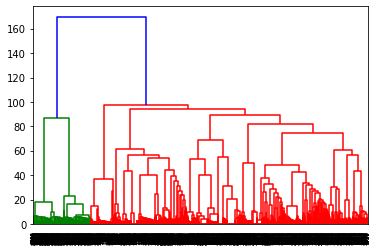

In [102]:
dend = dendrogram(linkage_data)

In [107]:
clusters = fcluster(linkage_data, 5, criterion='distance')

In [108]:
len(clusters), pd.Series(clusters).nunique()

(4607, 275)

In [110]:
sms_data_credit['sms_cluster'] = clusters

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [112]:
sms_data_credit.to_excel('./sms_data_credit.xlsx')

In [63]:
# Using TFIDF for text featurization

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [65]:
tfidf_vect = TfidfVectorizer()

In [73]:
tfidf = tfidf_vect.fit_transform(sms_data_credit['clean_smsbody'])
tfidf.shape

(4607, 4515)

In [74]:
model_tf = KMeans(n_clusters  = 4, n_jobs=-1, random_state=99)
model_tf.fit(tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=99, tol=0.0001, verbose=0)

In [75]:
labels_tf = model_tf.labels_
cluster_center_tf = model_tf.cluster_centers_

In [76]:
terms1  = tfidf_vect.get_feature_names()

In [77]:
terms1[1:10]

['000288795879adarsh',
 '00034',
 '004822244816',
 '005610015077',
 '005610158911',
 '005812855437',
 '005848474698',
 '005920958108',
 '0061']

In [78]:
from sklearn import metrics
silhouetter_score_tf = metrics.silhouette_score(tfidf, labels_tf, metric='euclidean')

In [79]:
silhouetter_score_tf

0.08902690697482532